## Matching Scales

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd
import math
import cmath

import pywt # PyWavelets

In [3]:
# NCL Output
sst_data = np.loadtxt("data/nino3sst_trimmed.txt")
time_0 = 1871.0
dt = 0.25  # years (4 per year, seasonal)

ncl_data = np.genfromtxt("data/ncl_csv.csv", skip_header=1, delimiter=',')
ncl_data = ncl_data[:,1]
time_range = (np.arange(0, len(ncl_data)) * dt) + time_0 # from 1871.00 to 1996.75
ncl_df = pd.DataFrame({'time (years)': time_range, 'temperature (C)': ncl_data})
ncl_df.head()

,time (years),temperature (C)
0,1871.00,-0.15
1,1871.25,-0.30
2,1871.50,-0.14
3,1871.75,-0.41
4,1872.00,-0.46


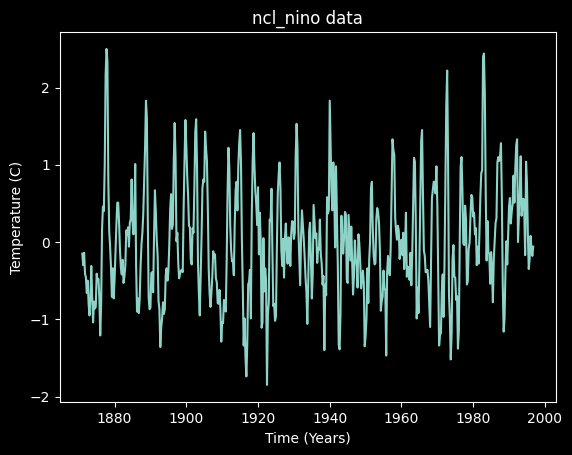

In [6]:
plt.style.use('dark_background')
fig, ax = plt.subplots()
fig = plt.plot(ncl_df["time (years)"], ncl_df["temperature (C)"])
plt.title("ncl_nino data")
plt.xlabel("Time (Years)")
plt.ylabel("Temperature (C)")
plt.show()

wavelets (32) (5, 7): 
['cmor0.5-0.5', 'cmor0.5-0.8', 'cmor0.5-1.0', 'cmor0.5-1.2', 'cmor0.8-0.5', 'cmor0.8-0.8', 'cmor0.8-1.0', 'cmor0.8-1.2', 'cmor1.0-0.5', 'cmor1.0-0.8', 'cmor1.0-1.0', 'cmor1.0-1.2', 'cmor1.2-0.5', 'cmor1.2-0.8', 'cmor1.2-1.0', 'cmor1.2-1.2', 'cmor1.5-0.5', 'cmor1.5-0.8', 'cmor1.5-1.0', 'cmor1.5-1.2', 'cmor1.8-0.5', 'cmor1.8-0.8', 'cmor1.8-1.0', 'cmor1.8-1.2', 'cmor2.0-0.5', 'cmor2.0-0.8', 'cmor2.0-1.0', 'cmor2.0-1.2', 'cmor2.2-0.5', 'cmor2.2-0.8', 'cmor2.2-1.0', 'cmor2.2-1.2']


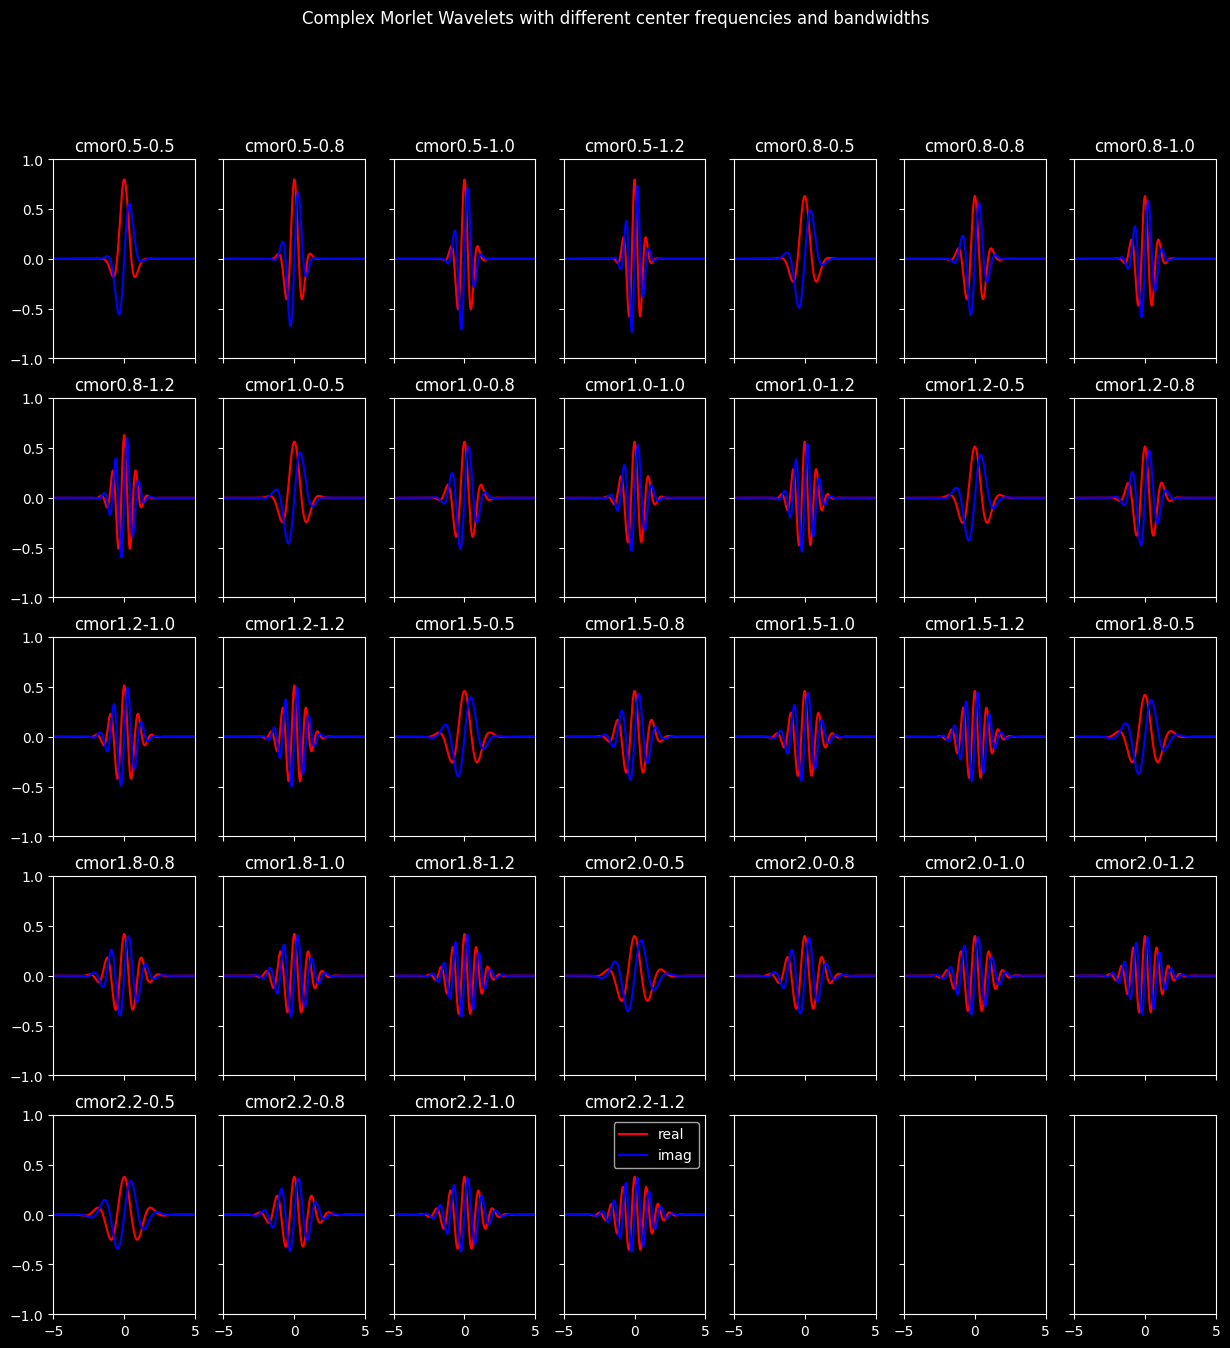

In [14]:
# PyWavelets complex morlet
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#wavelet-bandwidth-and-center-frequencies

# plot complex morlet wavelets with different center frequencies and bandwidths
x_range = np.arange(0.5, 2.5, 0.25)#[0.5, 1.5, 2.5]
y_range = np.arange(0.5, 1.5, 0.25)#[0.5, 1.0, 1.5]
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in x_range for y in y_range]
sub_plot_x = int(math.sqrt(len(wavelets)))
sub_plot_y = len(wavelets) - sub_plot_x**2
if sub_plot_y == 0: sub_plot_y = sub_plot_x
print(f"wavelets ({len(wavelets)}) ({sub_plot_x}, {sub_plot_y}): \n{wavelets}")
fig, axs = plt.subplots(sub_plot_x, sub_plot_y, figsize=(15, 15), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real", c="red")
    ax.plot(x, np.imag(psi), label="imag", c="blue")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with different center frequencies and bandwidths")
plt.show()

In [15]:
def complex_morlet_pywavelets(time_step, B, C):
    part1 = np.power(math.pi*B, -1/4)
    part2 = math.exp(-np.power(time_step, 2)/B)
    part3 = cmath.exp(1j * 2 * math.pi * C * time_step)
    return part1 * part2 * part3

def tc_morlet(time_step):
    i = np.sqrt(-1+0j) # complex i
    omega = 6 # w, nondimensional frequency, defaults to 6 (2pi)
    eta = time_step # n, wavelet function nondimensional "time" parameter
    part1 = np.power(math.pi, -1/4)
    part2 = np.power(math.e, i*omega*eta)
    part3 = np.power(math.e, -np.power(eta, 2)/2)
    return part1 * part2 * part3

range complex morlet function = (-0.4446918655151891, 0.5634742034204662)
range cmor morlet output      = (-0.5920340065547383, 0.750173133602921)
range tc morlet output        = (-0.6573192867703035, 0.7502759291315703)


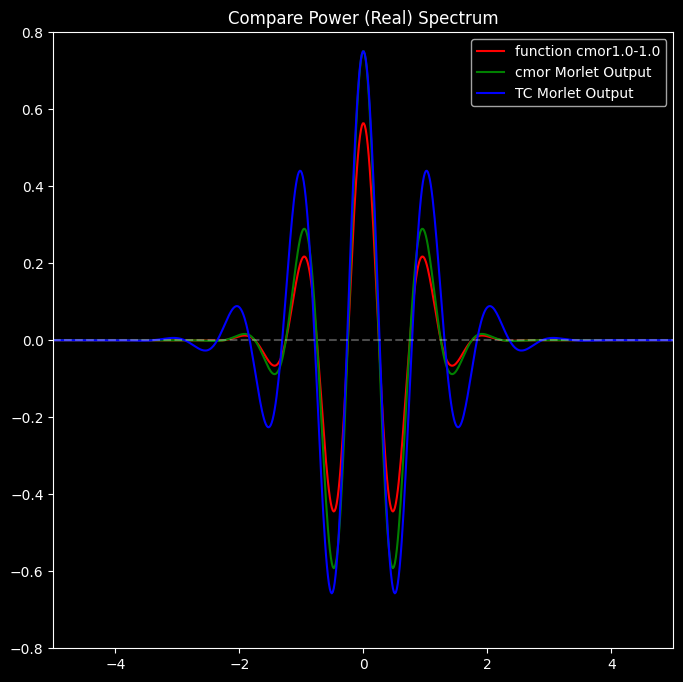

In [40]:
# Best Approx Wavelet

# cmorB-C
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
# B = bandwidth
# C = center frequency
bandwidth = 1.0
center_freq = 1.0 # C * 2 * pi = 1 * 2 * pi = approx 6 (morlet default)
complex_morlet = f"cmor{bandwidth}-{center_freq}"
[psi, x] = pywt.ContinuousWavelet(complex_morlet).wavefun(10)

tc_output = []
for x_value in x:
    tc_output.append(tc_morlet(x_value))

cmor_output = []
for x_value in x:
    cmor_output.append(complex_morlet_pywavelets(x_value, bandwidth, center_freq))

print(f"range complex morlet function = ({np.min(np.real(psi))}, {np.max(np.real(psi))})")
print(f"range cmor morlet output      = ({np.min(np.real(cmor_output))}, {np.max(np.real(cmor_output))})")
print(f"range tc morlet output        = ({np.min(np.real(tc_output))}, {np.max(np.real(tc_output))})")

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, np.real(psi), label=f"function {complex_morlet}", c="red")
ax.plot(x, np.real(cmor_output), label="cmor Morlet Output", c="green")
ax.plot(x, np.real(tc_output), label="TC Morlet Output", c="blue")
plt.title("Compare Power (Real) Spectrum")
ax.axhline(0, linestyle='--', alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-0.8, 0.8])
ax.legend()
plt.show()